# Import Libraries

In [1]:
# import secrets

import pandas as pd
import numpy as np
import pickle

import requests
# from secrets import api_key_alpha
import datetime
# import time

# Cleaning the Data

In [2]:
# Import data and convert date column to datetime datatype
raw_data = pd.read_csv('../data/historic_sentiment_analysis.csv')
raw_data['date'] = pd.to_datetime(raw_data['date'])

In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375 entries, 0 to 1374
Data columns (total 100 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   stock                               1375 non-null   object        
 1   Bearish                             1375 non-null   float64       
 2   Neutral                             1375 non-null   float64       
 3   Bullish                             1375 non-null   float64       
 4   Total_Compound                      1375 non-null   float64       
 5   date                                1375 non-null   datetime64[ns]
 6   assetType                           1375 non-null   object        
 7   assetMainType                       1375 non-null   object        
 8   cusip                               1375 non-null   object        
 9   symbol                              1375 non-null   object        
 10  description            

## Unnecessary Columns

Let's dig into dividend data. 

In [4]:
raw_data[['divYield', 'divAmount', 'divDate', 'dividendYield', 'dividendAmount', 'dividendDate']].head(10)

,divYield,divAmount,divDate,dividendYield,dividendAmount,dividendDate
0,0.00,0.00,NaN,0.00,0.00,
1,0.00,0.00,NaN,0.00,0.00,
2,0.00,0.00,NaN,0.00,0.00,
3,0.70,0.88,00:00.0,0.70,0.88,00:00.0
4,0.00,0.00,NaN,0.00,0.00,
5,0.00,0.00,NaN,0.00,0.00,
6,0.00,0.00,NaN,0.00,0.00,
7,0.00,0.00,NaN,0.00,0.00,
8,0.71,0.88,00:00.0,0.71,0.88,00:00.0
9,0.09,0.64,00:00.0,0.09,0.64,00:00.0


Most of the values are null/zero values because most stocks don't provide dividends.

Also, there are duplicate columns (ex: divAmount & dividendAmount).

For simplicity, let's consolidate them columns into one as follows:
1. Remove the dividendDate/divDate columns. Keeping this would be redundant
2. Remove divYield column, it contains the same information as divAmount
3. The information from the 6 columns is contained in divAmount:
    - Whether the stock pays a dividend or not
    - How much is paid per stock owned

Let's remove all columns related to dividend except 'divAmount'

In [5]:
raw_data.drop(['divYield', 'divDate', 'dividendYield', 'dividendAmount', 'dividendDate', 'dividendPayDate'], axis=1, inplace=True)

Several columns are either identifiers, duplicates or empty, we don't need them for this project

In [6]:
raw_data.drop(['cusip',
           'assetType',
           'description',
           'assetMainType',
           'symbol',
           'securityStatus',
           'symbol.1',
           'bidTick',
           'exchangeName',
           'peRatio.1'], axis=1, inplace=True)

Categorical columns

In [7]:
raw_data.select_dtypes(include='object')

,stock,bidId,askId,lastId,exchange
0,CLOV,P,P,P,q
1,CLNE,Q,P,P,q
2,TLRY,P,P,P,q
3,AAPL,P,P,D,q
4,WKHS,P,P,D,q
...,...,...,...,...,...
1370,SAVA,Q,U,D,q
1371,AAPL,Q,Q,K,q
1372,DKNG,U,V,Z,q
1373,LCID,Q,K,D,q


In [8]:
print(raw_data['bidId'].nunique())
print(raw_data['askId'].nunique())
print(raw_data['lastId'].nunique())
print(raw_data['exchange'].nunique())

15
15
15
1


exchange column has only 1 unique value, which would likely not add predictability

In [9]:
raw_data.drop(['exchange'], axis=1, inplace=True)

In [10]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375 entries, 0 to 1374
Data columns (total 83 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   stock                               1375 non-null   object        
 1   Bearish                             1375 non-null   float64       
 2   Neutral                             1375 non-null   float64       
 3   Bullish                             1375 non-null   float64       
 4   Total_Compound                      1375 non-null   float64       
 5   date                                1375 non-null   datetime64[ns]
 6   bidPrice                            1375 non-null   float64       
 7   bidSize                             1375 non-null   int64         
 8   bidId                               1375 non-null   object        
 9   askPrice                            1375 non-null   float64       
 10  askSize                 

## Boolean Values

In [11]:
raw_data.select_dtypes(include='boolean')

,marginable,shortable,delayed,realtimeEntitled
0,True,True,True,False
1,True,True,True,False
2,True,True,True,False
3,True,True,True,False
4,True,True,True,False
...,...,...,...,...
1370,True,True,True,False
1371,True,True,True,False
1372,True,True,True,False
1373,True,True,True,False


In [12]:
print(raw_data['marginable'].nunique())
print(raw_data['shortable'].nunique())
print(raw_data['delayed'].nunique())
print(raw_data['realtimeEntitled'].nunique())

2
2
1
1


Two of these columns provide no valuable information

In [13]:
raw_data.drop(['delayed', 'realtimeEntitled'], axis=1, inplace=True)

## Null Values

In [14]:
raw_data.isna().sum().sum()

0

We're good to go

## Columns with minimal unique values

Variables with a single value in the column will not likely provide any predictability

In [15]:
for column in list(raw_data.columns):
    if raw_data[column].nunique() <= 1:
        raw_data.drop(column, axis=1, inplace=True)

# Bring in price stock with Alpha Vantage API

In [16]:
# Date range of our dataset
print(raw_data['date'].min().date())
print(raw_data['date'].max().date())
print(raw_data['date'].max().date() - raw_data['date'].min().date())

2021-06-03
2021-11-05
155 days, 0:00:00


Based on the date range of our dataset, our API call should generate about 6 months of price history

In [159]:
def get_daily_adjusted_price_data(api_key, stock):
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={stock}&outputsize=full&apikey={api_key}"
    raw_data = requests.get(url).json()

    return raw_data

def create_dataframe(raw_data):
    dataframe = pd.DataFrame(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])

    for key in raw_data["Time Series (Daily)"].keys():
        dataframe = dataframe.append(
            pd.Series(
                [
                    datetime.datetime.strptime(key, '%Y-%m-%d'),
                    pd.to_numeric(raw_data["Time Series (Daily)"][key]['1. open']),
                    pd.to_numeric(raw_data["Time Series (Daily)"][key]["2. high"]),
                    pd.to_numeric(raw_data["Time Series (Daily)"][key]["3. low"]),
                    pd.to_numeric(raw_data["Time Series (Daily)"][key]["4. close"]),
                    pd.to_numeric(raw_data["Time Series (Daily)"][key]["5. adjusted close"]),
                    pd.to_numeric(raw_data["Time Series (Daily)"][key]["6. volume"])             
                ], index=dataframe.columns
            ), ignore_index=True
        )

    return dataframe

def add_column(dataframe, value_to_add, column_name):
    dataframe[f"{column_name}"] = [value_to_add for x in range(len(dataframe))]

    return dataframe

def calc_returns(dataframe, n_days):
    dataframe[f"{n_days}d-logreturn"] = np.log(dataframe['Adj Close'] / dataframe['Adj Close'].shift(n_days))

    return dataframe

def calc_direction(dataframe, n_days):
    dataframe[f"{n_days}d-direction"] = [1 if x > 0 else -1 if x < 0 else 0 for x in dataframe[f"{n_days}d-logreturn"]]

    return dataframe

def concat_dataframes(dataframe1, dataframe2):
    price_data = pd.concat([dataframe1, dataframe2], ignore_index=True)
    price_data = price_data[['Date',
                             'stock',
                             'Adj Close',
                             '1d-logreturn',
                             '1d-direction',
                             '2d-logreturn',
                             '2d-direction',
                             '5d-logreturn',
                             '5d-direction']]

    return price_data

def clean_dataframe(dataframe):
    # First n values in direction columns should be NaN
    dataframe['1d-direction'][0] = np.nan
    dataframe['2d-direction'][0: 2] = [np.nan for x in dataframe['2d-direction'][0: 2]]
    dataframe['5d-direction'][0: 5] = [np.nan for x in dataframe['5d-direction'][0: 5]]

    # Shift columnd to properly align in a manner to ensure the features are observable
    # with respectto the target
    dataframe['1d-logreturn'] = dataframe['1d-logreturn'].shift(1)
    dataframe['1d-direction'] = dataframe['1d-direction'].shift(1)

    dataframe['2d-logreturn'] = dataframe['2d-logreturn'].shift(1)
    dataframe['2d-direction'] = dataframe['2d-direction'].shift(1)

    dataframe['5d-logreturn'] = dataframe['5d-logreturn'].shift(1)
    dataframe['5d-direction'] = dataframe['5d-direction'].shift(1)

    dataframe.dropna(inplace=True)
    dataframe.reset_index(inplace=True)
    dataframe.drop('index', axis=1, inplace=True)

    return dataframe

In [160]:
# Caution: this piece takes several minutes to run
# STOCKS = list(raw_data['stock'].unique())
# bad_api_calls = []
# price_data = pd.DataFrame()

# for stock in STOCKS:

#     # Make api call
#     api_call = get_daily_adjusted_price_data(secrets.API_KEY_ALPHA_VANTAGE, stock)

#     try:
#         # Create dataframe
#         dataframe = create_dataframe(api_call)
#         # Add column for stock symbol
#         add_column(dataframe, stock, 'stock')

#         # Calc returns
#         calc_returns(dataframe, 1)
#         calc_returns(dataframe, 2)
#         calc_returns(dataframe, 5)

#         # Calc direction
#         calc_direction(dataframe, 1)
#         calc_direction(dataframe, 2)
#         calc_direction(dataframe, 5)

#         # Concat dataframes
#         price_data = concat_dataframes(price_data, dataframe)

#     except KeyError:
#         bad_api_calls.append(stock)
#         pass

#     time.sleep(13)

# clean_dataframe(price_data)

# print(len(STOCKS))
# print(len(bad_api_calls), "bad api calls")
# print(bad_api_calls)

There's still an issue with Alpha Vantage's API calls

In [161]:
# with open('../data/price_data.pickle', 'wb') as f:
#     pickle.dump(price_data, f)

with open('../data/price_data.pickle', 'rb') as f:
    price_data = pickle.load(f)

In [162]:
price_data.rename(
    {
    'Date':'date',
    'Adj Close': 'close'
    }, axis=1, inplace=True
)

In [163]:
# Filter out date range to focus on the particular dates in which the sentiment analysis was conducted
filter_ = (price_data['date'] >= raw_data['date'].min()) & (price_data['date'] <= raw_data['date'].max())

price_data = price_data[filter_]
price_data.reset_index(inplace=True)
price_data.drop('index', axis=1, inplace=True)

In [164]:
# In this step, we will combine the price dataset and a sentiment analysis dataset into one
# 'combined_df'
final_dataset = price_data.merge(raw_data, on=['date', 'stock'], how='left', suffixes=(None, "_y"))

In [165]:
# Drop extra columns that contain '_y' as a suffix
for column in final_dataset.columns.to_list():
    if column[-2:] == '_y':
        final_dataset.drop(labels=column, axis=1, inplace=True)

In [166]:
# Remove any duplcate columns resulted form the merge
final_dataset = final_dataset.loc[:, ~final_dataset.columns.duplicated()]
final_dataset.sort_values(by=['date', 'stock'], ignore_index=True, inplace=True)

In [167]:
# Now, what to do with NaN values?
# Bearish, Bullish, Neutral, and Total_Compound columns, fill with small value to indicate little to no sentiment on that day
fill_na_list = ['Bearish', 'Bullish', 'Neutral', 'Total_Compound']
for column_header in fill_na_list:
    final_dataset[column_header].fillna(value=0.005, inplace=True)

In [168]:
null_values_list = list(final_dataset.isna().sum()[final_dataset.isna().sum() > 0].index)
#print(combined_df.isna().sum().sum())

for indx in null_values_list:
    try:
        final_dataset[indx] = final_dataset.groupby('stock')[indx].transform(lambda x: x.fillna(x.mean()))
    except TypeError:
        pass

#print(combined_df.isna().sum().sum())

In [169]:
# Simply remove the remainder of the null values

print(len(final_dataset))

final_dataset.dropna(inplace=True)
final_dataset.reset_index(drop=True, inplace=True)

print(len(final_dataset))

7063
935


In [170]:
final_dataset.isna().sum().sum()

0

## Data types

In [171]:
# Convert columns to numeric datatype
int_list = ['bidSize', 'askSize', 'lastSize', 'totalVolume', 'regularMarketLastSize']

for int_ in int_list:
    final_dataset[int_] = pd.to_numeric(final_dataset[int_])

final_dataset['1d-direction'] = pd.to_numeric(final_dataset['1d-direction'])

In [172]:
final_dataset.select_dtypes('object').columns

Index(['stock', 'bidId', 'askId', 'lastId', 'marginable', 'shortable'], dtype='object')

In [173]:
# Some columns should be integer data types
final_dataset['sharesOutstanding'] = pd.to_numeric(final_dataset['sharesOutstanding'])
final_dataset['vol1DayAvg'] = pd.to_numeric(final_dataset['vol1DayAvg'])
final_dataset['vol10DayAvg'] = pd.to_numeric(final_dataset['vol10DayAvg'])
final_dataset['vol3MonthAvg'] = pd.to_numeric(final_dataset['vol3MonthAvg'])

In [174]:
final_dataset.select_dtypes(['int64', 'float64', 'int32', 'float32']).columns

Index(['close', '1d-logreturn', '1d-direction', '2d-logreturn', '2d-direction',
       '5d-logreturn', '5d-direction', 'Bearish', 'Neutral', 'Bullish',
       'Total_Compound', 'bidPrice', 'bidSize', 'askPrice', 'askSize',
       'lastPrice', 'lastSize', 'openPrice', 'highPrice', 'lowPrice',
       'closePrice', 'netChange', 'totalVolume', 'quoteTimeInLong',
       'tradeTimeInLong', 'mark', 'volatility', '52WkHigh', '52WkLow',
       'peRatio', 'divAmount', 'regularMarketLastPrice',
       'regularMarketLastSize', 'regularMarketNetChange',
       'regularMarketTradeTimeInLong', 'netPercentChangeInDouble',
       'markChangeInDouble', 'markPercentChangeInDouble',
       'regularMarketPercentChangeInDouble', 'high52', 'low52', 'pegRatio',
       'pbRatio', 'prRatio', 'pcfRatio', 'grossMarginTTM', 'grossMarginMRQ',
       'netProfitMarginTTM', 'netProfitMarginMRQ', 'operatingMarginTTM',
       'operatingMarginMRQ', 'returnOnEquity', 'returnOnAssets',
       'returnOnInvestment', 'quickRa

In [175]:
# Remove 52wk___ columns
# They gave me issues when calculating shapley values
# We still have high52 and low52 which should be the same thing anyway

final_dataset.drop(["52WkHigh", "52WkLow"], axis=1, inplace=True)
# There can't be numbers in the column names
final_dataset.rename({
    '5d-direction': 'direction',
    'high52': 'highfiftytwo',
    'low52': 'lowfiftytwo',
    'vol1DayAvg': 'volonedayavg',
    'vol10DayAvg': 'voltendayavg',
    'vol3MonthAvg': 'volthreemonthavg'},
    axis=1,
    inplace=True)

final_dataset.columns = final_dataset.columns.map(lambda row: "_".join(row.lower().split(" ")))
final_dataset = final_dataset.loc[:, 'direction':]

In [176]:
# Pickle the data
with open("../data/final_dataset.pickle", "wb") as f:
    pickle.dump(final_dataset, f)

Officially ready for modeling

# Minimal Viable Product

## Features and Target Variables

In [177]:
X = final_dataset.loc[:, 'bearish':]
y = final_dataset['direction']

## Encode Categorical Variables

In [178]:
from sklearn.preprocessing import OneHotEncoder

def encode_cats(categoricals, numericals, df):
    """
    Takes in a list of categorical columns and a list of numerical columns and returns the dataframe with encoded variables
    """
    ohe = OneHotEncoder(sparse=False, drop='first')
    cat_matrix = ohe.fit_transform(df.loc[:, categoricals])
    X_ohe = pd.DataFrame(cat_matrix,
                         columns=ohe.get_feature_names(categoricals), #create meaningful column names
                         index=X.index) #keep the same index values
    
    return pd.concat([X.loc[:, numericals], X_ohe], axis=1)

In [179]:
categoricals = list(X.select_dtypes('object').columns)
numericals = list(X.select_dtypes(['int64', 'float64', 'int32', 'float32']).columns)
X = encode_cats(categoricals, numericals, X)

# Make sure the X df has the same number of columns as the final_dataset df
categoricals = list(final_dataset.select_dtypes('object').columns)
numericals = list(final_dataset.select_dtypes(['int64', 'float64', 'int32', 'float32']).loc[:, 'bearish':].columns)
final_dataset = encode_cats(categoricals, numericals, final_dataset)
final_dataset['direction'] = y

assert int(len(X.columns) + 1) == len(final_dataset.columns), "Number of features do not match"

In [180]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import auc, roc_auc_score, plot_roc_curve, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay, plot_confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [181]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42) #hold out 20% of the data for final testing

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [182]:
knn = KNeighborsClassifier()
knn_scores = cross_val_score(knn, X_train_scaled, y_train, cv=5)

lr = LogisticRegression(max_iter=1000)
lr_scores = cross_val_score(lr, X_train_scaled, y_train, cv = 5)

rf = RandomForestClassifier()
rf_scores = cross_val_score(rf, X_train_scaled, y_train, cv=5)

gbm = xgb.XGBClassifier()
gbm_scores = cross_val_score(gbm, X_train_scaled, y_train, cv=5)

print(f"KNN mean scores: {np.mean(knn_scores):.4}")

print(f"Logistic Regression mean scores: {np.mean(lr_scores):.4}")

print(f"Random Forest mean scores: {np.mean(rf_scores):.4}")

print(f"XGBoost mean scores: {np.mean(gbm_scores):.4}")

# save best model
best_model = {
    knn: np.mean(knn_scores),
    lr: np.mean(lr_scores),
    rf: np.mean(rf_scores),
    gbm: np.mean(gbm_scores)
}

# sort by mean scores (dict values)
# then select the last model (highest mean scores)
best_model = {k: v for k, v in sorted(best_model.items(), key=lambda item: item[1])}
best_model = list(best_model.keys())[-1]

KNN mean scores: 0.5829
Logistic Regression mean scores: 0.603
Random Forest mean scores: 0.7112
XGBoost mean scores: 0.7192


## Confusion Matrix

In [183]:
# Precicion score
gbm.fit(X_train_scaled, y_train)
prec_score = precision_score(y_test, gbm.predict(X_test_scaled), average='weighted')

print(f"Precision Score: {prec_score:.4f}")

Precision Score: 0.7529


In [184]:
# Recall Score
rec_score = recall_score(y_test, gbm.predict(X_test_scaled), average='weighted')

print(f"Recall Score: {rec_score:.4f}")

Recall Score: 0.7540


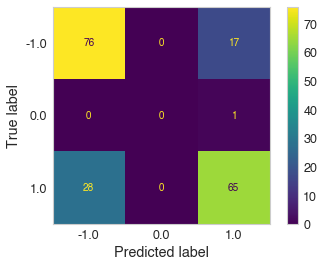

In [185]:
plot_confusion_matrix(gbm, X_test_scaled, y_test)
plt.grid(b=None)

## Class Imbalance

In [186]:
# Let's try to fix this imbalance to increase accuracy
# Almost 50% of the data are 1s or -1s, with minimal 0s
y_train.value_counts()

-1.0    392
 1.0    354
 0.0      2
Name: direction, dtype: int64

In [187]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

def over_under_sample(X_train, y_train, Under=True, Over=True):
    """
    Input: training features and target
    Output: under/oversampled datasets
    """
    rus = RandomUnderSampler(random_state=42)
    ros = RandomOverSampler(random_state=42)

    if Under and Over:
        X_train_under, y_train_under = rus.fit_sample(X_train, y_train)
        X_train_over, y_train_over = ros.fit_sample(X_train, y_train)

        return X_train_under, y_train_under, X_train_over, y_train_over

    elif Under:
        X_train_under, y_train_under = rus.fit_sample(X_train, y_train)

        return X_train_under, y_train_under
    else:
        X_train_over, y_train_over = ros.fit_sample(X_train, y_train)

        return X_train_over, y_train_over

In [188]:
X_train_scaled_over, y_train_over = over_under_sample(X_train_scaled, y_train, Under=False, Over=True)

In [189]:
gbm_scores_over = cross_val_score(gbm, X_train_scaled_over, y_train_over, cv=5)

print(f"XGBoost mean scores: {np.mean(gbm_scores_over):.4}")

XGBoost mean scores: 0.841


In [190]:
# Confusion Matrix and Recall/Precision scores
gbm_over = xgb.XGBClassifier()
gbm_over.fit(X_train_scaled_over, y_train_over)
prec_score = precision_score(y_test, gbm_over.predict(X_test_scaled), average='weighted')

print(f"Precision Score: {prec_score:.4f}")

Precision Score: 0.7553


In [191]:
# Recall Score
rec_score = recall_score(y_test, gbm_over.predict(X_test_scaled), average='weighted')

print(f"Recall Score: {rec_score:.4f}")

Recall Score: 0.7487


In [192]:
# Scores went down 2 points

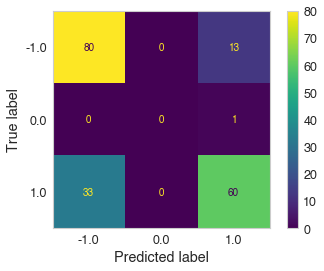

In [193]:
plot_confusion_matrix(gbm_over, X_test_scaled, y_test)
plt.grid(b=None)

## ROC AUC

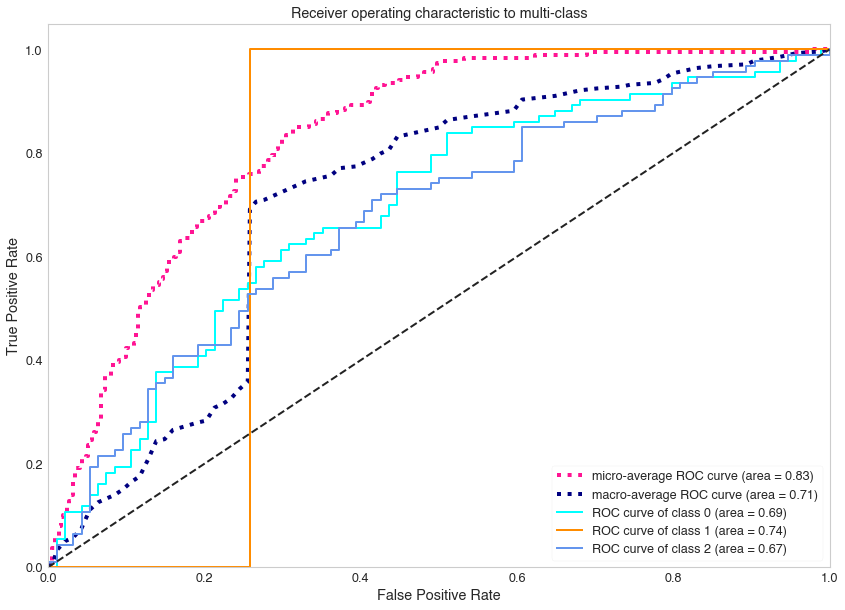

In [194]:
# Plot ROC area under the curve
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn import svm
from scipy import interp

# Binarize the output
y_roc_auc = label_binarize(y, classes=[-1, 0, 1])
n_classes = y_roc_auc.shape[1]

# shuffle and split training and test sets
X_train_roc_auc, X_test_roc_auc, y_train_roc_auc, y_test_roc_auc = train_test_split(X, y_roc_auc, test_size=.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled_roc_auc = scaler.fit_transform(X_train_roc_auc)
X_test_scaled_roc_auc = scaler.transform(X_test_roc_auc)

# Oversampling
# X_train_scaled_over, y_train_over = over_under_sample(X_train_scaled, y_train, Under=False, Over=True)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=42))
y_score = classifier.fit(X_train_scaled_roc_auc, y_train_roc_auc).decision_function(X_test_scaled_roc_auc)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], thresh = roc_curve(y_test_roc_auc[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_roc_auc.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(14, 10))
plt.grid(b=None)
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Model Explanation using SHAP

### Common Questions:
1. Why does the model predict what it predicts?
2. How much does each feature contribute to the difference between the final prediction and the average prediction?

In [199]:
from sklearn.metrics import f1_score

# Calculate f1 score
rf.fit(X_train_scaled, y_train)
y_preds = rf.predict(X_test_scaled)
f1 = f1_score(y_test, y_preds, average='weighted')
print(f1)

0.7213838300736697


In [200]:
from patsy import dmatrices
import shap
import re

# Make copy of our datasets because we need to change them up a bit
shapley_dataset = final_dataset.copy()

features_list = list(shapley_dataset.columns[1:])

y_shapley, X_shapley = dmatrices(
    "direction ~ " + " + ".join(features_list),
    data=shapley_dataset
)
X_frame = pd.DataFrame(data=X_shapley, columns=X_shapley.design_info.column_names)

# Fix column names
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_frame.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_frame.columns.to_list()]

explainer = shap.Explainer(rf)
shap_values = explainer.shap_values(X_frame)

In [208]:
X_shapley

DesignMatrix with shape (935, 110)
  Columns:
    ['Intercept',
     'neutral',
     'bullish',
     'total_compound',
     'bidprice',
     'bidsize',
     'askprice',
     'asksize',
     'lastprice',
     'lastsize',
     'openprice',
     'highprice',
     'lowprice',
     'closeprice',
     'netchange',
     'totalvolume',
     'quotetimeinlong',
     'tradetimeinlong',
     'mark',
     'volatility',
     'peratio',
     'divamount',
     'regularmarketlastprice',
     'regularmarketlastsize',
     'regularmarketnetchange',
     'regularmarkettradetimeinlong',
     'netpercentchangeindouble',
     'markchangeindouble',
     'markpercentchangeindouble',
     'regularmarketpercentchangeindouble',
     'highfiftytwo',
     'lowfiftytwo',
     'pegratio',
     'pbratio',
     'prratio',
     'pcfratio',
     'grossmarginttm',
     'grossmarginmrq',
     'netprofitmarginttm',
     'netprofitmarginmrq',
     'operatingmarginttm',
     'operatingmarginmrq',
     'returnonequity',
     '

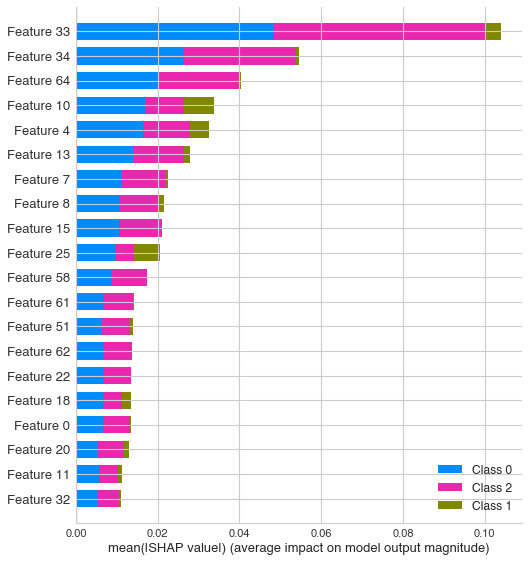

In [209]:
shap.initjs()
shap.summary_plot(shap_values, X_shapley)

In [ ]:
X_train

In [ ]:
X_frame

# Conclusion